# GATE (Listmode Reconstruction; With Time of Flight)

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta, PETTOFMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss
import gc

Required data:

In [2]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
# Paths to all ROOT files containing data
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23]) #path 23 corrupted

We can look at the information of our PET scanner:

In [3]:
info

{'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}

Set up time of flight metadata:

* Since GATE tracks the times, the time of flight bins can be set up however one wishes. The only thing that is dependent on the GATE simulation is `fwhm_tof_resolution`, which in our case is 550ps

In [4]:
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 1000 * speed_of_light #ps to position along LOR (full range)
num_tof_bins = 5
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

## Normalization Correction

In PET imaging, each detector crystal used in the scanner will have a different response to a uniform source due to its positioning (e.g. crystals at the end of edge of modules are different than those in the center). Adequate PET reconstruction takes this into account by first performing a calibration scan for a scanner and obtaining a normalization correction factor for each crystal pair LOR

**The cell below only needs to be ran once**, and may take a long time, as it requires opening and parsing through all the ROOT files corresponding to the normalization scan. Once it is ran, the normalization weights corresponding to each pair of detector IDs will be obtained (due to geometry/crystal orientation).

 This particular calibration scan was done using a thin cylindrical shell. We can compute $\eta$ using a particular function in the gate functionality of PyTomography. Then we save it as a `torch.Tensor` file for easy access in the next part. For this we need

* `cylinder_radius`: The radius of the thin cylindrical shell used for calibration

In [ ]:
normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]

# Get normalization weights for all possible detector ID pairs
normalization_weights = gate.get_normalization_weights_cylinder_calibration(
    normalization_paths,
    info,
    cylinder_radius = 320 # mm (radius of calibration cylindrical shell,
    include_randoms=False 
)

torch.save(normalization_weights, os.path.join(path, 'normalization_weights.pt'))

Once the cell above has been ran once, it can be opened as follows:

In [5]:
normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))

## Primary-Only Reconstruction

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data (i.e. we will manually exclude all scatters/randoms). We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [6]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids = gate.get_detector_ids_from_root(
    paths,
    info,
    tof_meta = tof_meta,
    include_randoms=False,
    include_scatters=False)
detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins
torch.save(detector_ids, os.path.join(path, 'detector_ids_tof_primary_only.pt'))

In [6]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids = torch.load(os.path.join(path, 'detector_ids_tof_primary_only.pt'))

We reconstruct PET listmode data as follows:

* Note: in this case, our sensitivity weights only have contribution from the normalization factor $\eta$ (and not attenuation $\mu$), so we need to include the attenuation map in the system matrix to get the true sensitivity weights

In [7]:
# Specify object space for reconstruction
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
# Get projection space metadata from PET geometry information dictionary
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=tof_meta,
    weights_sensitivity=normalization_weights
    )
# Get attenuation map and PSF transform from the associated phantom
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
psf_transform = GaussianFilter(4) # 4mm gaussian blurring
# Create system matrix.
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    attenuation_map = atten_map,
    N_splits=8,
)
# Create likelihood. For listmode reconstruction, projections don't need to be provided, since all detection events are stored in proj_meta
likelihood = PoissonLogLikelihood(
    system_matrix,
)
# Initialize reconstruction algorithm
recon_algorithm = OSEM(likelihood)
# Reconstruct
recon_primaryonly = recon_algorithm(n_iters=50, n_subsets=1)

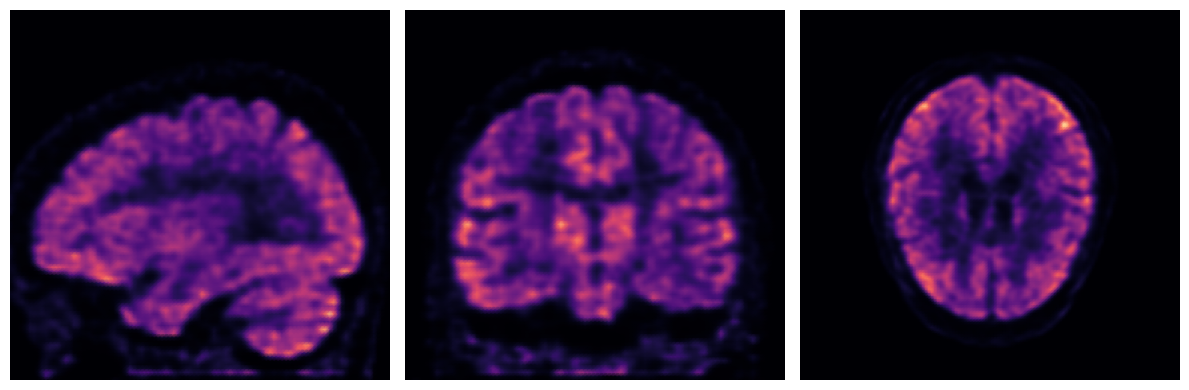

In [8]:
vmax = 0.15
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

## Reconstruction With Random/Scatter Estimation

For reconstruction of all events, we need to estimate boths randoms and scatters. Lets now get **all** events that were obtained in GATE:

In [8]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids = gate.get_detector_ids_from_root(
    paths,
    info,
    tof_meta=tof_meta
    )
detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins
torch.save(detector_ids, os.path.join(path, 'detector_ids_tof_all_events.pt'))

In [9]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids = torch.load(os.path.join(path, 'detector_ids_tof_all_events.pt'))

### Randoms

In addition to the first two steps of the non-TOF procedure (obtaining a random sinogram and smoothing), we now also need to account for the fact that the number of randoms in each TOF bin is proportional to the length of the TOF bin divided by the total coincidence timing width. We can do this using the `randoms_sinogram_to_sinogramTOF` function, and then converting back to listmode.

 First lets get all the delayed coincidence events:

In [ ]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids_delays = gate.get_detector_ids_from_root(
    paths,
    info,
    substr = 'delay')
torch.save(detector_ids_delays, os.path.join(path, 'detector_ids_delays.pt'))

In [10]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids_delays= torch.load(os.path.join(path, 'detector_ids_delays.pt'))

The procedure is

1. Convert listmode delays to sinogram
2. Smooth sinogram
3. Convert sinogram to TOF sinogram
4. Convert TOF sinogram to TOF listmode events

In [11]:
sinogram_randoms_estimate = gate.listmode_to_sinogram(
    detector_ids_delays,
    info
)
sinogram_randoms_estimate = gate.smooth_randoms_sinogram(
    sinogram_randoms_estimate,
    info,
    sigma_r=4,
    sigma_theta=4,
    sigma_z=4
)
sinogram_randoms_estimate = gate.randoms_sinogram_to_sinogramTOF(
    sinogram_randoms_estimate,
    tof_meta = tof_meta,
    coincidence_timing_width = 4300
) # coinicidence timing window for this GATE simulation was set to 4300ps
lm_randoms_estimate = gate.sinogram_to_listmode(
    detector_ids,
    sinogram_randoms_estimate,
    info,
)

### Scatters

Like before (non-TOF listmode tutorial), lets get an initial reconstruction without scatter

In [12]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    weights_sensitivity=normalization_weights,
    tof_meta=tof_meta
    )
psf_transform = GaussianFilter(4)
system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       attenuation_map=atten_map.to(pytomography.device),
)
lm_norm = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_randoms_estimate / lm_norm
additive_term[additive_term.isnan()] = 0 # remove NaN values
# Provide the random-only 
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(50,1)

Now we perform the scatter estimate and convert back to listmode (like in the previous non-TOF tutorial). There are two additional parameters we need to provide to the function for TOF:

1. `tof_meta`: Provides all the required TOF metadata
2. `num_dense_tof_bins`: The emission integrals in Watson [CITE] are split into multiple regions: this specifies the number of regions. This is independent and seperate from any of the information in `tof_meta`.

**Note: this takes ~10 minutes to run**

In [13]:
scatter_sinogram = sss.get_sss_scatter_estimate(
        object_meta,
        proj_meta,
        recon_without_scatter_estimation,
        atten_map,
        system_matrix,
        sinogram_random=sinogram_randoms_estimate,
        tof_meta=tof_meta,
        num_dense_tof_bins=25)
lm_scatter_estimate = gate.sinogram_to_listmode(proj_meta.detector_ids, scatter_sinogram, proj_meta.info)
# Save memory, these are not needed anymore
del(scatter_sinogram)
del(sinogram_randoms_estimate)
gc.collect()

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


6

Finally, we can perform the reconstruction including both scatters and randoms for estimation.

In [14]:
additive_term = (lm_scatter_estimate + lm_randoms_estimate) / lm_norm
additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_lm_tof = recon_algorithm(50,1)

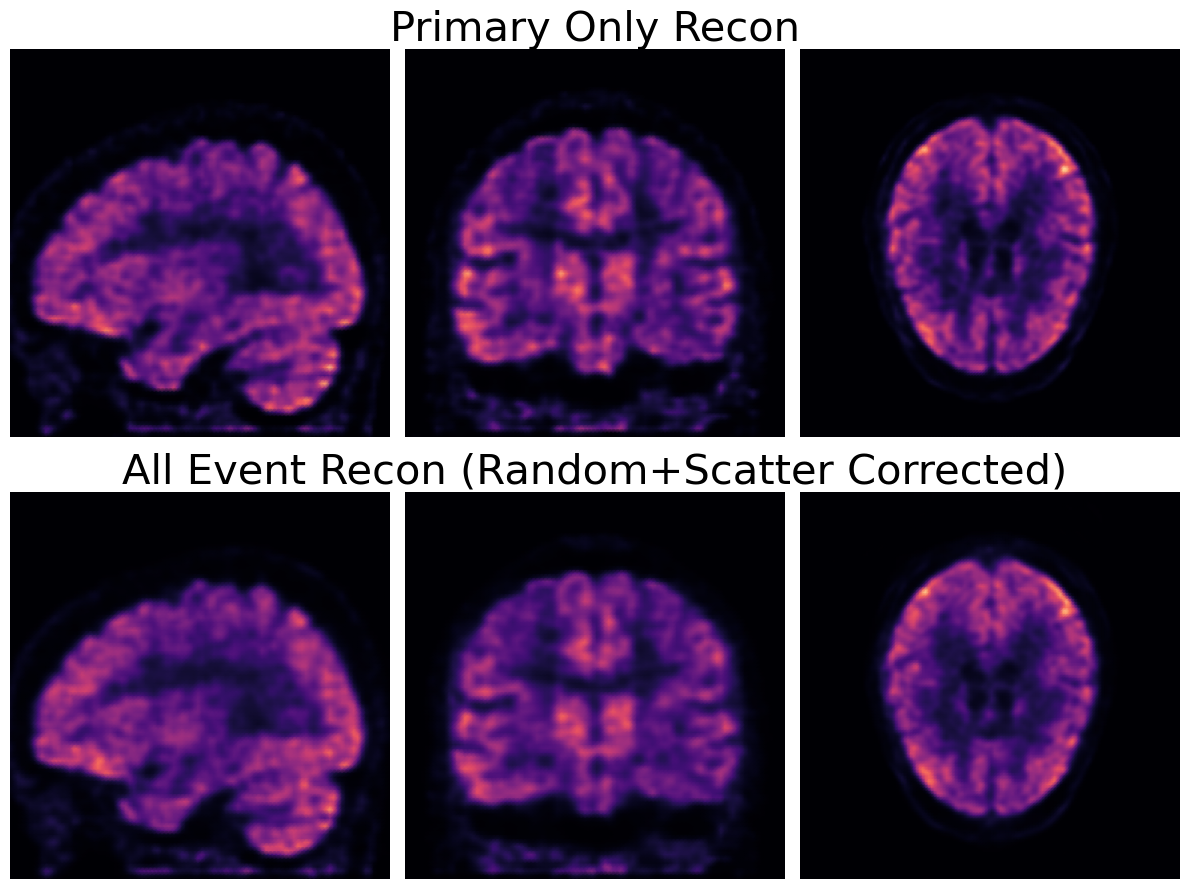

In [15]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_lm_tof[48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_lm_tof[16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_lm_tof[:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
fig.tight_layout()
plt.show()